In [6]:
!pip install tensorflow
!pip install tensorflow_hub
!pip install -q -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

In [7]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
from official.nlp import optimization
import os
import pandas as pd

In [8]:
dataset = pd.read_csv("/content/dataset_jp.csv")
dataset = dataset.drop('type', axis=1)
# Cetak dataset pelatihan
print("List Dataset:")
print(dataset)

List Dataset:
    label                                                 JP
0       J  Saya suka merencanakan segala sesuatu dengan t...
1       J  Saya suka membuat rencana dan mengikuti jadwal...
2       J  Saya suka merencanakan dan mengatur segala hal...
3       J  Saya lebih nyaman ketika memiliki jadwal yang ...
4       J  Saya suka membuat rencana dan menjalankannya d...
..    ...                                                ...
315     J  Saya termasuk dalam kategori judger yang cende...
316     J  Saya tidak pernah bekerja santai untuk mencapa...
317     J  Dalam bergaul, tidak jarang terlihat keras tap...
318     J  Sangat memperhatikan perkembangan orang-orang ...
319     J  Tidak hanya diam dengan perkembangan orang lai...

[320 rows x 2 columns]


In [9]:
df = pd.DataFrame(dataset)
df['JP'] = df['JP'].str.strip()

# Membagi dataset berdasarkan kelompok
grouped = df.groupby('label')

# Inisialisasi DataFrame train dan valid
df_train = pd.DataFrame()
df_valid = pd.DataFrame()

# Memproses setiap kelompok
for name, group in grouped:
    # Menentukan jumlah data untuk validasi
    valid_size = int(len(group) * 0.2)

    # Memilih data untuk validasi
    valid_data = group.sample(n=valid_size, random_state=42)

    # Memilih data untuk train
    train_data = group.drop(valid_data.index)

    # Menggabungkan hasil pemisahan ke dalam DataFrame train dan valid
    df_train = pd.concat([df_train, train_data])
    df_valid = pd.concat([df_valid, valid_data])

#acak
df_train = df_train.sample(frac=1, random_state=42)
df_valid= df_valid.sample(frac=1, random_state=42)

# Cetak hasil
print("Data Train:")
print(df_train)
print("\nData Valid:")
print(df_valid)

Data Train:
    label                                                 JP
245     P  Fleksibel juga sih, gak suka aturan yang ketat...
6       J  Menurutku, kejujuran dan konsistensi itu penti...
179     J  Ketika ada masalah, tidak pernah tidak punya k...
216     P  Ngga suka dibatasi aturan ketat, lebih suka ng...
308     J  Saya tidak suka jika tidak merancang jadwal un...
..    ...                                                ...
293     J  Walau tenggelam dalam kesenangan taman, saya t...
20      J  Merencanakan kegiatan atau proyek menjadi sala...
197     J  Sering juga suka mikirin masa depan, jadi gua ...
104     P  Terkadang lebih enjoy kalo bisa ngikutin alur ...
287     J  Saya menemukan kepuasan dalam perencanaan dan ...

[256 rows x 2 columns]

Data Valid:
    label                                                 JP
115     P  Fleksibel dalam menyikapi perubahan, gak terla...
217     P  Intinya, hidup itu harus santai, ngikutin arus...
185     J  Aku tidak suka jika tidak

In [10]:
train_data = df_train
valid_data = df_valid
target_label = 'P' #label 1 Perceiving
label_train = (train_data['label'].str[0] == target_label).astype(int).to_numpy()
label_valid = (valid_data['label'].str[0] == target_label).astype(int).to_numpy()

In [11]:
x_train = train_data['JP'].to_numpy() #isi sesuai kolom dataset
x_valid = valid_data['JP'].to_numpy()
print(x_train.shape,x_valid.shape)
print(label_train)
print(x_train)

(256,) (64,)
[1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0
 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0
 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0
 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1
 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1
 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0
 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0]
['Fleksibel juga sih, gak suka aturan yang ketat-ketat. Gue suka ambil keputusan spontan, dan ya, hidup gue nggak terlalu terencana banget, tapi seru aja gitu.'
 'Menurutku, kejujuran dan konsistensi itu penting dalam segala hal yang kulakukan'
 'Ketika ada masalah, tidak pernah tidak punya kecakapan untuk menemukan solusi yang sederhana dan praktis'
 'Ngga suka dibatasi aturan ketat, lebih suka ngikutin alur kehidupan yang santai dan fleksibel. Sering juga impul

In [12]:
encoder_url = 'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-l-12-h-768-a-12/versions/4'
preprocess_url = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-preprocess/versions/3"
embedding_model1 = hub.KerasLayer(encoder_url, trainable=True)
# embedding_model2 = hub.KerasLayer(encoder_url, trainable=True)
# embedding_model3 = hub.KerasLayer(encoder_url, trainable=True)
# embedding_model4 = hub.KerasLayer(encoder_url, trainable=True)
preprocess_model1 = hub.KerasLayer(preprocess_url)
# preprocess_model2 = hub.KerasLayer(preprocess_url)
# preprocess_model3 = hub.KerasLayer(preprocess_url)
# preprocess_model4 = hub.KerasLayer(preprocess_url)

In [13]:
def build_classifier_model():
    text_input1 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text1')
#     text_input2 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text2')
#     text_input3 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text3')
#     text_input4 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text4')

    # Gunakan lapisan pre-processing terpisah untuk setiap input
    preprocessing_layer1 = hub.KerasLayer(preprocess_model1, name='preprocessing1')
#     preprocessing_layer2 = hub.KerasLayer(preprocess_model1, name='preprocessing2')
#     preprocessing_layer3 = hub.KerasLayer(preprocess_model1, name='preprocessing3')
#     preprocessing_layer4 = hub.KerasLayer(preprocess_model1, name='preprocessing4')

    encoder_inputs1 = preprocessing_layer1(text_input1)
#     encoder_inputs2 = preprocessing_layer2(text_input2)
#     encoder_inputs3 = preprocessing_layer3(text_input3)
#     encoder_inputs4 = preprocessing_layer4(text_input4)

    encoder1 = hub.KerasLayer(embedding_model1, name='BERT_encoder_1', trainable=True)
#     encoder2 = hub.KerasLayer(embedding_model1, name='BERT_encoder_2', trainable=True)
#     encoder3 = hub.KerasLayer(embedding_model1, name='BERT_encoder_3', trainable=True)
#     encoder4 = hub.KerasLayer(embedding_model1, name='BERT_encoder_4', trainable=True)

    outputs1 = encoder1(encoder_inputs1)['pooled_output']
#     outputs2 = encoder2(encoder_inputs2)['pooled_output']
#     outputs3 = encoder3(encoder_inputs3)['pooled_output']
#     outputs4 = encoder4(encoder_inputs4)['pooled_output']

    # Add a Flatten layer to handle varying input lengths
#     outputs1 = tf.keras.layers.Flatten()(outputs1)
#     outputs2 = tf.keras.layers.Flatten()(outputs2)
#     outputs3 = tf.keras.layers.Flatten()(outputs3)
#     outputs4 = tf.keras.layers.Flatten()(outputs4)
    outputs1 = tf.keras.layers.Dropout(0.5 , name="dropout")(outputs1)

    label1 = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier1')(outputs1)
#     label2 = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier2')(outputs2)
#     label3 = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier3')(outputs3)
#     label4 = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier4')(outputs4)

#     concatenated_outputs = tf.keras.layers.concatenate([label1, label2, label3, label4], name='output')

    return tf.keras.Model(inputs=[text_input1], outputs=[label1])


In [14]:
model = build_classifier_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text1 (InputLayer)          [(None,)]                    0         []                            
                                                                                                  
 preprocessing1 (KerasLayer  {'input_word_ids': (None,    0         ['text1[0][0]']               
 )                           128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

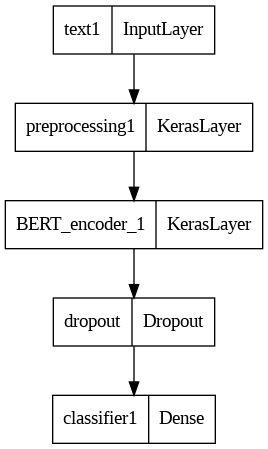

In [15]:
tf.keras.utils.plot_model(model)

In [16]:
epochs = 5
steps_per_epoch = 16
batch_size = 2
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)

In [17]:
!pip install -q tf-models-official

In [18]:
# model.compile(optimizer=optimizer,
#                          loss=loss,
#                          metrics=metrics)
# model.load_weights("/content/drive/MyDrive/model_checkpoint_best.h5")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
              loss=tf.keras.losses.BinaryCrossentropy(),  # Fungsi kerugian untuk klasifikasi biner
              metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Path untuk menyimpan checkpoint pada setiap epoch
checkpoint_path_epoch = "/content/drive/MyDrive/model_checkpoint_epoch.h5"

# Path untuk menyimpan checkpoint model terbaik
checkpoint_path_best = "/content/drive/MyDrive/model_checkpoint_best.h5"

# Callback untuk menyimpan checkpoint pada setiap epoch
checkpoint_callback_epoch = ModelCheckpoint(
    filepath=checkpoint_path_epoch,
    save_weights_only=True,
    save_best_only=False,  # Set ke False agar menyimpan pada setiap epoch
    verbose=1
)

# Callback untuk menyimpan checkpoint model terbaik
checkpoint_callback_best = ModelCheckpoint(
    filepath=checkpoint_path_best,
    save_weights_only=True,
    save_best_only=True,  # Set ke True agar hanya menyimpan model terbaik
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [20]:
# untuk lanjut
model.fit(
    x=x_train, y=label_train,
    epochs=20,
    validation_data=(x_valid, label_valid),batch_size=batch_size,
)

Epoch 1/20
128/128 [==============================] - 70s 200ms/step - loss: 0.7120 - accuracy: 0.4844 - val_loss: 0.6697 - val_accuracy: 0.5625
Epoch 2/20
128/128 [==============================] - 17s 131ms/step - loss: 0.6790 - accuracy: 0.5547 - val_loss: 0.6295 - val_accuracy: 0.7656
Epoch 3/20
128/128 [==============================] - 14s 107ms/step - loss: 0.5829 - accuracy: 0.7500 - val_loss: 0.5331 - val_accuracy: 0.7812
Epoch 4/20
128/128 [==============================] - 14s 108ms/step - loss: 0.4612 - accuracy: 0.8164 - val_loss: 0.3860 - val_accuracy: 0.8594
Epoch 5/20
128/128 [==============================] - 14s 106ms/step - loss: 0.3255 - accuracy: 0.9023 - val_loss: 0.2823 - val_accuracy: 0.8750
Epoch 6/20
128/128 [==============================] - 14s 109ms/step - loss: 0.2216 - accuracy: 0.9492 - val_loss: 0.2306 - val_accuracy: 0.9219
Epoch 7/20
128/128 [==============================] - 14s 113ms/step - loss: 0.1369 - accuracy: 0.9570 - val_loss: 0.1990 - val_ac

In [ ]:
model.predict(["saya suka berpikir kreatif dan liar"])

In [21]:
# Mendapatkan daftar perangkat yang tersedia (CPU dan GPU)
devices = tf.config.list_physical_devices()

if len(devices) == 0:
    print("Tidak ada perangkat fisik yang ditemukan.")
else:
    print("Perangkat yang tersedia:")
    for device in devices:
        print(f"- {device.name} ({device.device_type})")

Perangkat yang tersedia:
- /physical_device:CPU:0 (CPU)
- /physical_device:GPU:0 (GPU)


In [22]:
print(model.predict(["Cenderung fleksibel dan terbuka terhadap perubahan yang terjadi di sekitarnya."])) #Perceiving

1/1 [==============================] - 1s 751ms/step
[[0.99106467]]


In [23]:
print(model.predict(["cenderung terorganisir dan suka membuat keputusan yang terstruktur dalam kehidupan mereka."])) #Judging

1/1 [==============================] - 0s 166ms/step
[[0.00164611]]
